In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import skimage 

from sklearn import datasets, svm

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA, FastICA, DictionaryLearning
from sklearn.manifold import TSNE

from sklearn.linear_model import Lasso

from sklearn.datasets import load_digits, make_regression, fetch_olivetti_faces

from sklearn.inspection import DecisionBoundaryDisplay

from time import time
from scipy import sparse, linalg

import seaborn as sns

import pandas as pd

from PIL import Image
import base64
import io

import altair as alt

import fnmatch
from os.path import isfile,join
import os

In [32]:
## Given eight mixture signals
XT = np.array([
    [1.0, 1.0, 2.0, 0.0, 5.0, 4.0, 5.0, 3.0],
    [3.0, 2.0, 3.0, 3.0, 4.0, 5.0, 5.0, 4.0]
])

## Centering the data
means = np.mean(XT, axis = 1)
DT = (XT.T - means).T 
print(DT)

array([[-1.625, -1.625, -0.625, -2.625,  2.375,  1.375,  2.375,  0.375],
       [-0.625, -1.625, -0.625, -0.625,  0.375,  1.375,  1.375,  0.375]])

In [65]:
## Covariance matrix
Cov_mat = np.dot(DT, DT.T)/7

U, s, VT = np.linalg.svd(Cov_mat,  full_matrices=False)

print("Eigen vectors:")
print(VT)

print("Eigen values:")
s = np.diag(s)
print(s)


Eigen vectors:
[[-0.89554989 -0.44496113]
 [-0.44496113  0.89554989]]
Eigen values:
[[4.53931268 0.        ]
 [0.         0.28211589]]


Whitening: decorrelating (using PCA) and then rescaling

In [58]:
## Projecting the centered data onto the PCA space 
UT = np.dot(VT, DT)
print(UT)

## Check that e two mixture signals are decorrelated by projecting them
## onto the PCA space
np.dot(UT, UT.T)/7

[[ 1.73336927  2.17833039  0.83781938  2.62891915 -2.2937914  -1.84320264
  -2.73875252 -0.50269163]
 [ 0.16334315 -0.73220673 -0.28161797  0.60830428 -0.72095147  0.61955954
   0.17459842  0.16897078]]


array([[4.53931268e+00, 3.01346250e-16],
       [3.01346250e-16, 2.82115892e-01]])

In [79]:
## Signals are then rescaled to be with a unit variance
s_scale = np.power(np.diagonal(s), -0.5)
ZT = s_scale[:, np.newaxis] * UT

## Check that the the covariance matrix of the whitened data is the
## identity matrix, which means that the data are decorrelated and have unit variance.
np.dot(ZT, ZT.T)/7

array([[1.00000000e+00, 2.22044605e-16],
       [2.22044605e-16, 1.00000000e+00]])

# FastICA

In [3]:
rng = np.random.RandomState(0)

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)
print(faces_centered.shape)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("Centered data shape:", faces_centered.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/wesliao/scikit_learn_data
(400, 4096)
Dataset consists of 400 faces
Centered data shape: (400, 4096)


(400, 4096)


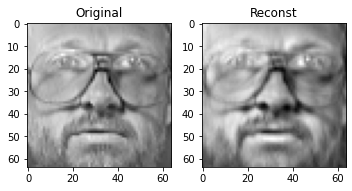

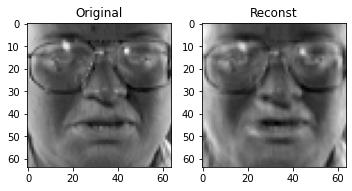

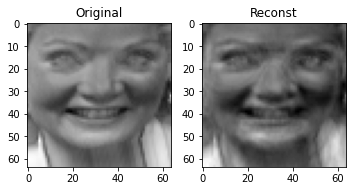

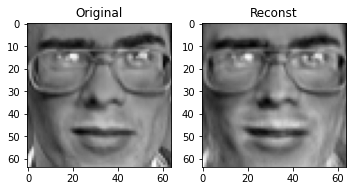

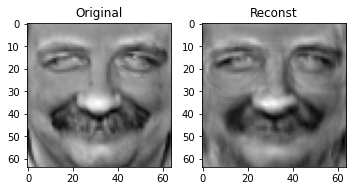

In [4]:
num_comp = 100

##After center the data, FastICA decorrelated data using PCA, and and whiten the PCA space
fast_ica = FastICA(n_components = num_comp, whiten = "unit-variance", max_iter = 1000)
fast_ica.fit(faces_centered)

## Fit and transform the data. Represent the original data with fewer components
face_ica = fast_ica.fit_transform(faces_centered)

## Reconstruct the original data 
face_reconstruct = fast_ica.inverse_transform(face_ica)
print("Shape of Reconstruct data:",face_reconstruct.shape)

## Compare the original with reconstruct from FastICA
for original, reconst in zip(faces_centered[:5], face_reconstruct[:5]):
    original = original.reshape(64,64)
    reconst = reconst.reshape(64,64)
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    ax = axes.ravel()
    ax[0].imshow(original, cmap=plt.cm.gray)
    ax[0].set_title("Original")
    ax[1].imshow(reconst, cmap=plt.cm.gray)
    ax[1].set_title("Reconst")
    fig.tight_layout()
    plt.show()

In [10]:
face_ica.shape

(400, 100)

Check the IC shape:
(100, 4096)
Check the mixing matrix shape:
(4096, 100)


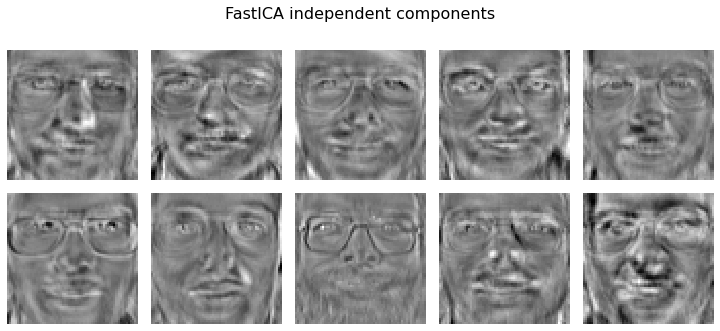

In [9]:
print("Check the IC shape:")
print(fast_ica.components_.shape)

print("Check the mixing matrix shape:")
print(fast_ica.mixing_.shape)

## Get the FastICA components. Each components has dimension same as the original data's feature
ic = fast_ica.components_

def plot_gallery(title, images, image_shape, n_col, n_row, cmap=plt.cm.gray):
    ## Input array "Images" is 2-dimensional.
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.1, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, img_vect in zip(axs.flat, images):
        vmax = max(img_vect.max(), -img_vect.min())
        im = ax.imshow(
            img_vect.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    plt.show()
    
plot_gallery("FastICA independent components", ic[:10], image_shape=(64,64),n_col=5, n_row=2)
    

# Dictionary Learning

In [27]:
dict_learning = DictionaryLearning(n_components = 20, alpha = 1, transform_algorithm = "lasso_lars",
                                  positive_code = False, random_state=rng, max_iter = 1000)


dict_learning.fit(faces_centered)

DictionaryLearning(n_components=20,
                   random_state=RandomState(MT19937) at 0x12420DC40,
                   transform_algorithm='lasso_lars')

In [14]:
## Get the atoms
dict_elements = dict_learning.components_

print("Shape of the dictionary (a set of atoms) that performs well at sparsely encoding the fitted data:", 
     dict_elements.shape)


Shape of the dictionary (a set of atoms) that performs well at sparsely encoding the fitted data: (100, 4096)


In [28]:
## Fit to data, then transform it
dict_fit_face = dict_learning.fit_transform(faces_centered)

In [26]:
## We can check the level of sparsity of the fit_transformed data:
np.mean(dict_fit_face == 0)

0.96595

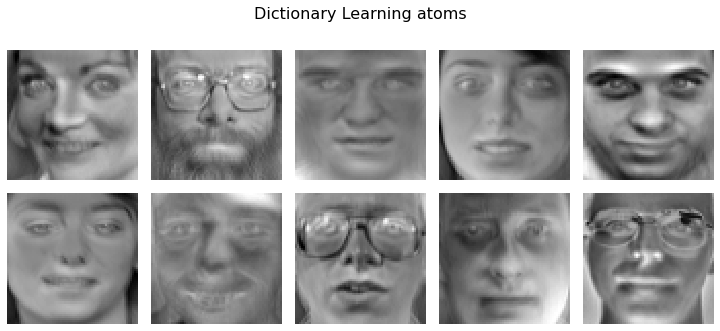

In [17]:
plot_gallery("Dictionary Learning atoms", dict_elements[:10], image_shape=(64,64),n_col=5, n_row=2)

In [1]:
64*64

4096